<a href="https://colab.research.google.com/github/mathluva/Bert-Toxic-Comments/blob/main/Toxic_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Feb 17 15:55:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf

In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 507), reused 1383 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 34.01 MiB/s, done.
Resolving deltas: 100% (507/507), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [4]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 71kB 4.5MB/s 
     |████████████████████████████████| 215kB 9.5MB/s 
     |████████████████████████████████| 296kB 53.3MB/s 
     |████████████████████████████████| 102kB 16.0MB/s 
     |████████████████████████████████| 25.9MB 125kB/s 
     |████████████████████████████████| 174kB 61.1MB/s 
     |████████████████████████████████| 3.7MB 56.6MB/s 
     |████████████████████████████████| 706kB 53.6MB/s 
     |████████████████████████████████| 358kB 55.7MB/s 
     |████████████████████████████████| 1.2MB 52.0MB/s 
     |████████████████████████████████| 11.5MB 201kB/s 
     |████████████████████████████████| 37.6MB 86kB/s 
     |████████████████████████████████| 645kB 41.3MB/s 
     |████████████████████████████████| 2.2MB 52.7MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
ERROR: pandas-gbq 0.13.3 has requirement google-cloud-b

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import files
uploaded = files.upload()

Saving train_preprocessed.csv to train_preprocessed (2).csv


In [5]:
import io
df = pd.read_csv(io.BytesIO(uploaded['train_preprocessed.csv']))

In [6]:
df.shape

(159571, 10)

In [10]:
df.tail(5)

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity
159566,and for the second time of asking when your ...,ffe987279560d7ff,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
159567,you should be ashamed of yourself that is a ho...,ffea4adeee384e90,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
159568,spitzer umm theres no actual article for pros...,ffee36eab5c267c9,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
159569,and it looks like it was actually you who put ...,fff125370e4aaaf3,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
159570,and i really don t think you understand i ca...,fff46fc426af1f9a,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0


<AxesSubplot:title={'center':'Toxicity'}, ylabel='Frequency'>

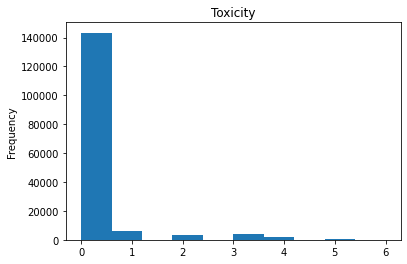

In [11]:
df['toxicity'].plot(kind = 'hist', title = 'Toxicity')

In [12]:
train_df, remaining = train_test_split(df, random_state = 42, train_size = .8, stratify = df['toxicity'].values)
valid_df, _ = train_test_split(remaining, random_state = 42, train_size = .2, stratify = remaining['toxicity'].values)


In [13]:
print(f'remaining shape: {remaining.shape}')
print(f'training shape: {train_df.shape}')
print(f'validation shape: {valid_df.shape}')

remaining shape: (31915, 10)
training shape: (127656, 10)
validation shape: (6383, 10)


In [24]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_df['comment_text'].values, train_df['identity_hate'].values, train_df['insult'].values,train_df['obscene'].values,train_df['severe_toxic'].values,train_df['threat'].values,train_df['toxic'].values))
    valid_data = tf.data.Dataset.from_tensor_slices((valid_df['comment_text'].values, valid_df['identity_hate'].values, valid_df['insult'].values,valid_df['obscene'].values,valid_df['severe_toxic'].values,valid_df['threat'].values,valid_df['toxic'].values ))
    sample = train_data.take(5) #take at look at 5 tensors
    
for element in sample.as_numpy_iterator():
  print(element)

(b'comment signed by jackthomas', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(b'the article is written in neutral language  it was sourced from all relevant and known news media available  if you can add more reference material i would be interested in seeing it ', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(b' have sheperd instead  ', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(b'  support conjuring is objectively a conceit  an open pretence that magic  paranormal  is in use magic  paranormal  is the originating concept in this sense the big question though is do the masses really care about the original against my expectations  yes they do this article gets more hits than magic  illusion  does this result plus primacy as the concept behind the names of all the  spinoffs  leads me to support this ', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(b' we do need a team to maintain it correctly  quote  andrew wallace  ', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


In [48]:
#label categories
label_list =['identity_hate',	'insult',	'obscene', 'severe_toxic',	'threat',	'toxic'	]
max_seq_length = 512
# Get BERT layer and tokenizer:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)

vocab_file = vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

#use uncase version of BERT
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

#FullTokenizer from BERT handles all the preprocessing of incoming raw text data
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [66]:
#Transform data into a format BERT understands. 
#Create InputExamples using classifier_data_lib's constructor InputExample provided in the BERT library.
def to_feature(text, label1,label2,label3,label4,label5,label6, label_list = label_list, max_seq_length = max_seq_length, tokenizer=tokenizer):
  
  #input example used by BERT
  example = classifier_data_lib.InputExample(guid = None, text_a = text.numpy(),
                                             text_b = None, 
                                             label = label.numpy())
   # 0 for first index
  feature = classifier_data_lib.convert_single_example(0,example, label_list,tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  

In [67]:
#Wrap python function into a TensorFlow op
#The tf.py_function will pass regular tensors (with a value and a .numpy() method to access it), to the wrapped python function.

def to_feature_map(text, label1,label2,label3,label4,label5,label6 ):
  #wrapping to_feature function, input is text, label, tensor output is int32 -create one for each
  input_ids, input_mask, segment_ids, label_id1 , label_id2, label_id3, label_id4, label_id5, label_id6= tf.py_function(to_feature, inp = [text, label1,label2,label3,label4,label5,label6 ], Tout = [tf.int32,tf.int32, tf.int32, tf.int32, tf.int32, tf.int32,tf.int32,tf.int32, tf.int32])

  #create padding for constant sequence length
  input_ids.set_shape(max_seq_length)
  input_mask.set_shape(max_seq_length)
  segment_ids.set_shape(max_seq_length)
  label_id1.set_shape([]) 
  label_id2.set_shape([]) 
  label_id3.set_shape([]) 
  label_id4.set_shape([]) 
  label_id5.set_shape([]) 
  label_id6.set_shape([])   

  #bundle features into dictionary
  x = { 'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
       }
  
  return (x, label_id1 , label_id2, label_id3, label_id4, label_id5, label_id6)


In [68]:
#Wrap python function into a TensorFlow op
#The tf.py_function will pass regular tensors (with a value and a .numpy() method to access it), to the wrapped python function.

def to_feature_map(text, label1,label2,label3,label4,label5,label6 ):
  #wrapping to_feature function, input is text, label, tensor output is int32 -create one for each
  input_ids, input_mask, segment_ids, label_id1 , label_id2, label_id3, label_id4, label_id5, label_id6= tf.py_function(to_feature, inp = [text, label1,label2,label3,label4,label5,label6 ], Tout = [tf.int32,tf.int32, tf.int32, tf.int32, tf.int32, tf.int32,tf.int32,tf.int32, tf.int32])

  #create padding for constant sequence length
  input_ids.set_shape(max_seq_length)
  input_mask.set_shape(max_seq_length)
  segment_ids.set_shape(max_seq_length)
  label_id1.set_shape([]) 
  label_id2.set_shape([]) 
  label_id3.set_shape([]) 
  label_id4.set_shape([]) 
  label_id5.set_shape([]) 
  label_id6.set_shape([]) 

  #bundle features into dictionary
  x = { 'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
       }
  
  return (x, label_id1 , label_id2, label_id3, label_id4, label_id5, label_id6)


In [69]:
#Create a TensorFlow Input Pipeline with tf.data
with tf.device('/cpu:0'):
  train_data = (train_data.map(to_feature_map, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid, do everything except shuffling
  valid_data = (valid_data.map(to_feature_map, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder = True)
  .prefetch( tf.data.experimental.AUTOTUNE))

In [70]:
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 512), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 512), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [71]:
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 512), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 512), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [80]:
#copy from documentation
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  #segment_id from doc
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output) #hyperparameter, add dropout regularization
  output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(drop) # sigmoid for probability
  model = tf.keras.Model(
     inputs ={
         'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': input_type_ids
       },
       outputs = output)
  return model

In [81]:
model = create_model()
#very small learning rate for this activity
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics =[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

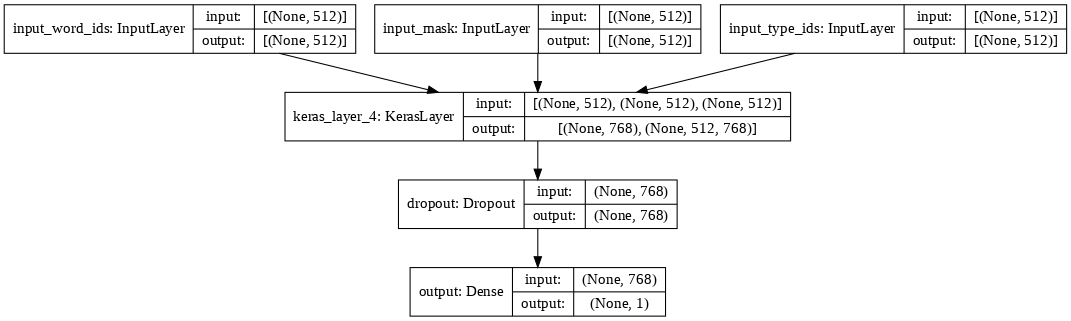

In [74]:
tf.keras.utils.plot_model(model = model, show_shapes=True, dpi = 76)

In [75]:
# Train model
#fit data to model
#takes about 10 min to train
epochs = 4 
history = model.fit(train_data, validation_data= valid_data, epochs = epochs, verbose =1)


Epoch 1/4


ValueError: ignored